Enter the parameters for Cuckoo Search Algorithm:
Enter the population size (n): 6
Enter the fraction of worse nests to abandon (Pa): 0.2
Enter the maximum number of iterations (Max iterations): 5
Iteration 1, Best ITAE: 173.55869456840477
Iteration 2, Best ITAE: 126.93245973719709
Iteration 3, Best ITAE: 126.93245973719709
Iteration 4, Best ITAE: 125.66134951624593
Iteration 5, Best ITAE: 82.33517652869465

Best PID Parameters Found (Kp, Ki, Kd): [-4.03647528 -3.52657855 -0.77682762]
Best ITAE Value: 82.33517652869465


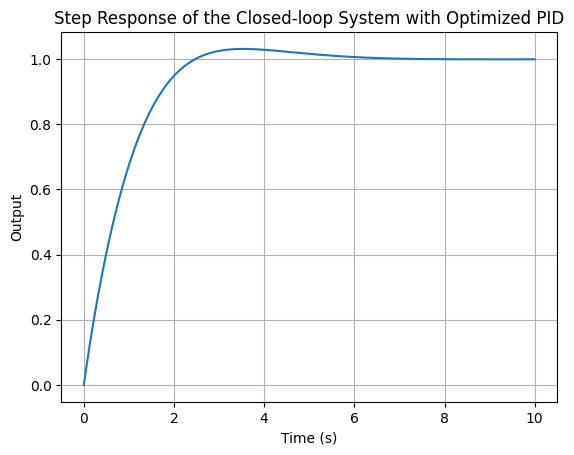

Sparsha Srinath Kadaba - 1BM22CS287


In [11]:
# 4. Cuckoo Search (CS):
# Application - Traveling Salesman Problem

import numpy as np
import math
import scipy.signal as signal
import matplotlib.pyplot as plt

# Objective function to optimize (PID tuning using ITAE)
def objective_function(params):
    Kp, Ki, Kd = params
    # Define the transfer function of the plant (simple first-order system)
    plant = signal.TransferFunction([1], [1, 1])  # G(s) = 1 / (s + 1)

    # Define the PID controller transfer function
    pid = signal.TransferFunction([Kd, Kp, Ki], [1, 0])  # G_PID(s) = Kd*s + Kp + Ki/s

    # Manually compute the closed-loop transfer function:
    # G_closed(s) = G_pid(s) * G_plant(s) / (1 + G_pid(s) * G_plant(s))
    num = np.polymul(pid.num, plant.num)  # Multiply the numerators
    den = np.polyadd(np.polymul(pid.num, plant.den), np.polymul(pid.den, plant.num))  # Add the denominators

    closed_loop = signal.TransferFunction(num, den)

    # Time vector for simulation
    t = np.linspace(0, 10, 1000)

    # Step response of the closed-loop system (desired output is a step input)
    _, yout = signal.step(closed_loop, T=t)

    # Desired output is a step function, so error is the difference
    desired_output = np.ones_like(yout)
    error = np.abs(desired_output - yout)

    # Calculate ITAE (Integral of Time-weighted Absolute Error)
    itae = np.sum(t * error)  # Approximate integral using sum
    return itae

# Function to perform Levy flight
def levy_flight(Lambda=1.5, size=None):
    sigma = (math.gamma(1 + Lambda) * math.sin(np.pi * Lambda / 2) /
             math.gamma((1 + Lambda) / 2) * Lambda ** ((Lambda - 1) / 2)) ** (1 / Lambda)

    u = np.random.normal(0, sigma, size=size)
    v = np.random.normal(0, 1, size=size)

    step = u / np.abs(v) ** (1 / Lambda)
    return step

# Cuckoo Search Algorithm for PID optimization
def cuckoo_search(n, Pa, max_iter, dim, objective_function):
    # Initialize population (n nests, dim-dimensional)
    nests = np.random.uniform(-5, 5, (n, dim))  # Randomly initializing nests (Kp, Ki, Kd)
    fitness = np.apply_along_axis(objective_function, 1, nests)

    # Best solution
    best_nest = nests[np.argmin(fitness)]
    best_fitness = np.min(fitness)

    for t in range(max_iter):
        # Generate new solutions using Lévy flight
        new_nests = np.copy(nests)
        for i in range(n):
            new_nests[i] += levy_flight(size=dim) * np.random.randn()

        # Evaluate fitness of new nests
        new_fitness = np.apply_along_axis(objective_function, 1, new_nests)

        # Replace worse nests with new solutions
        for i in range(n):
            if new_fitness[i] < fitness[i]:
                nests[i] = new_nests[i]
                fitness[i] = new_fitness[i]

        # Abandon some worst nests and build new ones
        num_to_replace = int(Pa * n)

        # Ensure num_to_replace is within valid range (cannot exceed n)
        num_to_replace = min(num_to_replace, n)

        worst_nests_idx = np.argsort(fitness)[-num_to_replace:]
        nests[worst_nests_idx] = np.random.uniform(-5, 5, (num_to_replace, dim))
        fitness[worst_nests_idx] = np.apply_along_axis(objective_function, 1, nests[worst_nests_idx])

        # Find the current best solution
        current_best_nest = nests[np.argmin(fitness)]
        current_best_fitness = np.min(fitness)

        if current_best_fitness < best_fitness:
            best_nest = current_best_nest
            best_fitness = current_best_fitness

        # Print iteration info (optional)
        print(f"Iteration {t+1}, Best ITAE: {best_fitness}")

    return best_nest, best_fitness

def get_user_input():
    # Get user input for the algorithm parameters
    print("Enter the parameters for Cuckoo Search Algorithm:")
    n = int(input("Enter the population size (n): "))  # Number of nests
    Pa = float(input("Enter the fraction of worse nests to abandon (Pa): "))  # Fraction of worse nests
    max_iter = int(input("Enter the maximum number of iterations (Max iterations): "))  # Max iterations
    dim = 3  # PID parameters: Kp, Ki, Kd

    # Ensure Pa is between 0 and 1
    if Pa < 0:
        print("Pa cannot be negative. Setting Pa to 0.")
        Pa = 0
    elif Pa > 1:
        print("Pa cannot be greater than 1. Setting Pa to 1.")
        Pa = 1

    return n, Pa, max_iter, dim

def main():
    # Get user inputs
    n, Pa, max_iter, dim = get_user_input()

    # Run the Cuckoo Search algorithm
    best_solution, best_value = cuckoo_search(n, Pa, max_iter, dim, objective_function)

    # Output the best PID parameters and ITAE value
    print("\nBest PID Parameters Found (Kp, Ki, Kd):", best_solution)
    print("Best ITAE Value:", best_value)

    # Plot the best system response with optimized PID parameters
    Kp, Ki, Kd = best_solution
    plant = signal.TransferFunction([1], [1, 1])
    pid = signal.TransferFunction([Kd, Kp, Ki], [1, 0])

    # Manually compute the closed-loop transfer function
    num = np.polymul(pid.num, plant.num)  # Multiply the numerators
    den = np.polyadd(np.polymul(pid.num, plant.den), np.polymul(pid.den, plant.num))  # Add the denominators
    closed_loop = signal.TransferFunction(num, den)

    t = np.linspace(0, 10, 1000)
    _, yout = signal.step(closed_loop, T=t)

    plt.plot(t, yout)
    plt.title("Step Response of the Closed-loop System with Optimized PID")
    plt.xlabel("Time (s)")
    plt.ylabel("Output")
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()

print("Sparsha Srinath Kadaba - 1BM22CS287")